In [1]:
import joblib
import pandas as pd

from src.data_loader import load_data
from src.preprocessing import clean_data
from src.features import build_features

df = load_data()
df = clean_data(df)
df = build_features(df)

model = joblib.load("../models/churn_model.pkl")

TARGET = "Churn"

X = df.drop(columns=[TARGET, "customerID", "MultipleLines", "InternetService", "Contract", "PaymentMethod"])
y = df[TARGET]


In [2]:
import shap

explainer = shap.TreeExplainer(model)

sample = X.sample(1000, random_state=42)  # быстрее

shap_values = explainer.shap_values(sample)


/home/adam/projects/data-science/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


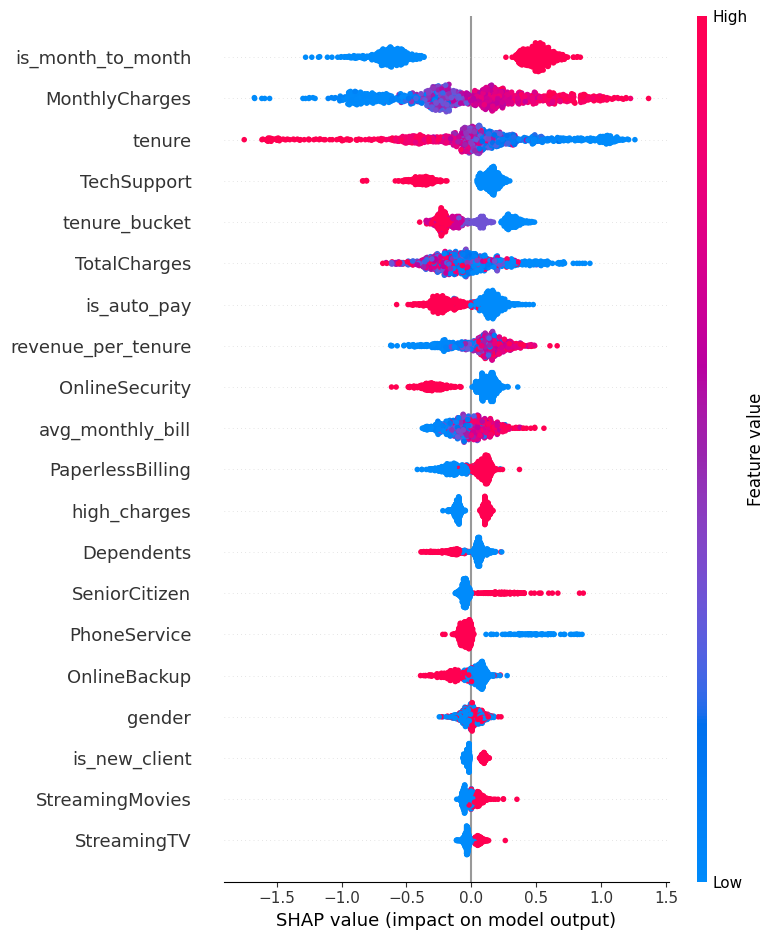

In [3]:
shap.summary_plot(shap_values, sample)


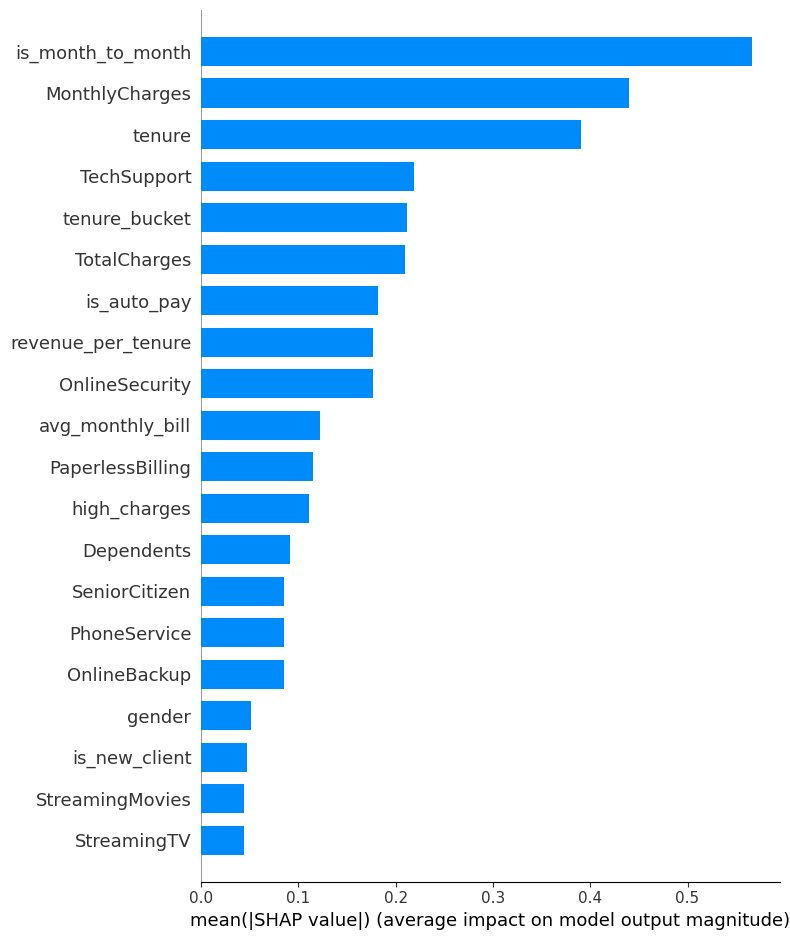

In [4]:
shap.summary_plot(shap_values, sample, plot_type="bar")


In [5]:
i = 5

shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    sample.iloc[i]
)


In [6]:
df["churn_proba"] = model.predict_proba(X)[:, 1]


In [7]:
def risk_segment(p):
    if p < 0.3:
        return "low"
    elif p < 0.6:
        return "medium"
    else:
        return "high"

df["risk_segment"] = df["churn_proba"].apply(risk_segment)

df["risk_segment"].value_counts()


risk_segment
low       4476
medium    1438
high      1118
Name: count, dtype: int64

In [8]:
df.groupby("risk_segment").agg(
    clients=("Churn", "count"),
    churn_rate=("Churn", "mean"),
    avg_revenue=("TotalCharges", "mean")
)


,clients,churn_rate,avg_revenue
risk_segment,,,
high,1118,0.849732,878.315206
low,4476,0.055183,2788.604357
medium,1438,0.467316,1802.794993


In [9]:
RETENTION_COST = 50
PROFIT = 300

df["expected_profit"] = (
    df["churn_proba"] * PROFIT - RETENTION_COST
)


In [10]:
target_clients = df[df["expected_profit"] > 0]

len(target_clients)


3414

## Основные драйверы churn
- Month-to-month контракт
- Высокий MonthlyCharges
- Малый tenure

## Рекомендации маркетингу
- скидки новым клиентам
- перевод на годовой контракт
- автоплатеж
- таргетировать только клиентов с positive expected_profit
